## Volatility Regime Switching model
$$
r_t = .043 − .022 r_{t−1} + \sigma_t + u_t
$$

$$
u_t = \sigma_t \epsilon_t, \epsilon_t \sim \phi (0,1)
$$

$$
\sigma^{2}_t = .098 u^{2}_{t−1} + .954 \sigma^2_{t−1}, if u_{t−1} \leq 0
$$
$$
\sigma^{2}_t = .06 + 0.46 u^{2}_{t−1} + .8854 \sigma^2_{t−1}, if u_{t−1} > 0
$$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import plt

In [2]:
np.random.seed(123)

In [3]:
def rng(time_steps):
    rn = np.random.standard_normal((time_steps, 1))
    rn -= rn.mean()
    rn /= rn.std()
    return rn

In [4]:
def vrs_model(time_steps=500):
    eps = rng(time_steps)
    r = np.zeros(time_steps)
    u = np.zeros(time_steps)
    sigma2 = np.zeros(time_steps)
    sigma2[0] = np.sqrt(0.06)
    
    for i in range(1, time_steps):
        if u[i-1] <= 0:
            sigma2[i] = .098 * u[i-1]**2 + .954 * sigma2[i-1]
        else:
            sigma2[i] = .06 + .046 * u[i-1]**2 + .8854*sigma2[i-1]
        
        u[i] = np.sqrt(sigma2[i])*eps[i]
        r[i] = .043 - .22 * r[i-1] + np.sqrt(sigma2[i]) + u[i]
            
    return r, np.sqrt(sigma2)

In [5]:
r, vol = vrs_model(time_steps=500)
fdiff_r = r[1:]- r[:-1]

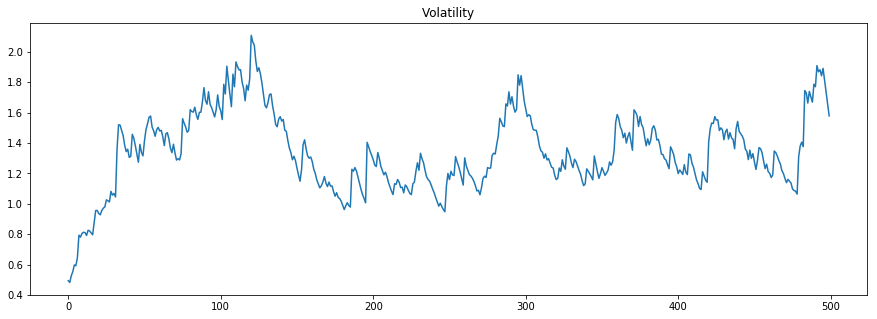

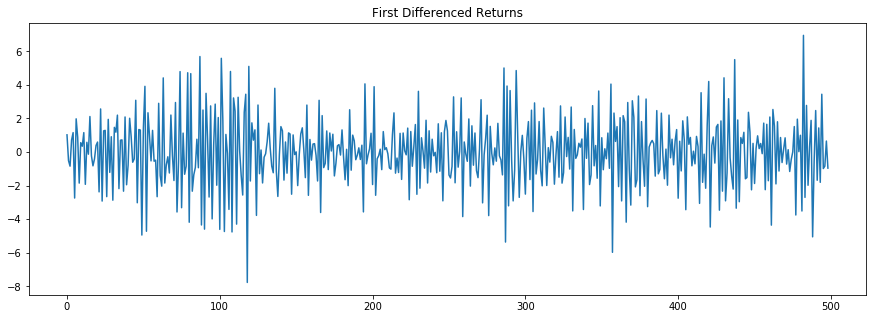

In [6]:
plt.figure(figsize=(15,5))
plt.title('Volatility')
plt.plot(vol);

plt.figure(figsize=(15,5))
plt.title('First Differenced Returns')
plt.plot(fdiff_r);

In [7]:
df = pd.DataFrame(fdiff_r, columns=['vrs_model'], index=range(499))

In [8]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['vrs_model'].shift(lag)

df = df.dropna(how='any')

In [9]:
Y = df[['vrs_model']].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [10]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

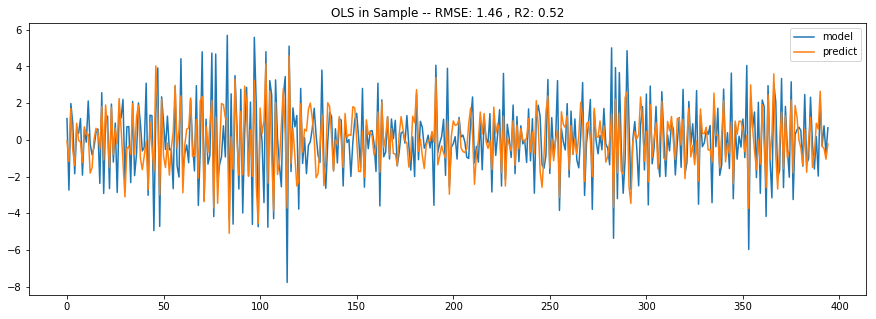

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
ols_in_sample = results.fittedvalues
plt.plot(ols_in_sample, label='predict')
# calculate root mean squared error
ols_train_rmse = np.sqrt(mean_squared_error(train_Y.flatten(), ols_in_sample))
plt.title('OLS in Sample -- RMSE: %.2f , R2: %.2f' % (ols_train_rmse, r2_score(train_Y.flatten(), ols_in_sample)))
plt.legend(loc=0)
plt.show()

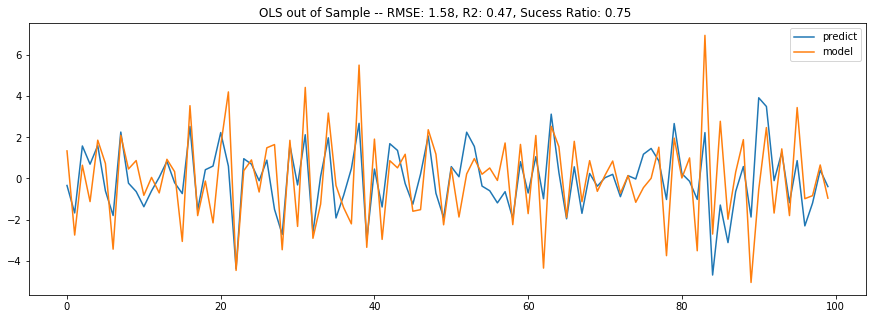

In [13]:
ols_out_sample = results.predict(test_X)
plt.figure(figsize=(15, 5))
plt.plot(ols_out_sample, label='predict')
plt.plot(test_Y, label='model')
# calculate root mean squared error
ols_test_rmse = np.sqrt(mean_squared_error(test_Y.flatten(), ols_out_sample))
# Success ratio
sr = np.mean(np.sign(ols_out_sample)==np.sign(test_Y.flatten()))
plt.title('OLS out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (ols_test_rmse, r2_score(test_Y.flatten(), ols_out_sample), sr))
plt.legend(loc=0)
plt.show()

## Deep Learning with Keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [19]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [20]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [52]:
model = Sequential()
model.add(Dense(3, input_dim=lags))
#model.add(Activation('tanh'))
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=[success_ratio, r_coeff])

In [53]:
history = model.fit(train_X, train_Y, 
                    epochs=6000,
                    batch_size=len(train_X),
                    verbose=2,
                    validation_data=(test_X, test_Y), shuffle=True, 
                   )

Train on 395 samples, validate on 100 samples
Epoch 1/6000
0s - loss: 9.2384 - success_ratio: 0.3797 - r_coeff: -1.0529e+00 - val_loss: 10.1144 - val_success_ratio: 0.3600 - val_r_coeff: -1.1350e+00
Epoch 2/6000
0s - loss: 9.2058 - success_ratio: 0.3797 - r_coeff: -1.0457e+00 - val_loss: 10.0790 - val_success_ratio: 0.3600 - val_r_coeff: -1.1275e+00
Epoch 3/6000
0s - loss: 9.1733 - success_ratio: 0.3797 - r_coeff: -1.0385e+00 - val_loss: 10.0438 - val_success_ratio: 0.3600 - val_r_coeff: -1.1200e+00
Epoch 4/6000
0s - loss: 9.1409 - success_ratio: 0.3772 - r_coeff: -1.0313e+00 - val_loss: 10.0086 - val_success_ratio: 0.3800 - val_r_coeff: -1.1126e+00
Epoch 5/6000
0s - loss: 9.1087 - success_ratio: 0.3772 - r_coeff: -1.0241e+00 - val_loss: 9.9735 - val_success_ratio: 0.3900 - val_r_coeff: -1.1052e+00
Epoch 6/6000
0s - loss: 9.0767 - success_ratio: 0.3747 - r_coeff: -1.0170e+00 - val_loss: 9.9385 - val_success_ratio: 0.3900 - val_r_coeff: -1.0978e+00
Epoch 7/6000
0s - loss: 9.0447 - succe

Epoch 158/6000
0s - loss: 5.8618 - success_ratio: 0.4886 - r_coeff: -3.0260e-01 - val_loss: 6.4137 - val_success_ratio: 0.4600 - val_r_coeff: -3.5380e-01
Epoch 159/6000
0s - loss: 5.8481 - success_ratio: 0.4886 - r_coeff: -2.9956e-01 - val_loss: 6.3991 - val_success_ratio: 0.4600 - val_r_coeff: -3.5071e-01
Epoch 160/6000
0s - loss: 5.8345 - success_ratio: 0.4886 - r_coeff: -2.9653e-01 - val_loss: 6.3845 - val_success_ratio: 0.4600 - val_r_coeff: -3.4764e-01
Epoch 161/6000
0s - loss: 5.8209 - success_ratio: 0.4911 - r_coeff: -2.9352e-01 - val_loss: 6.3700 - val_success_ratio: 0.4600 - val_r_coeff: -3.4458e-01
Epoch 162/6000
0s - loss: 5.8074 - success_ratio: 0.4911 - r_coeff: -2.9052e-01 - val_loss: 6.3555 - val_success_ratio: 0.4600 - val_r_coeff: -3.4153e-01
Epoch 163/6000
0s - loss: 5.7940 - success_ratio: 0.4911 - r_coeff: -2.8753e-01 - val_loss: 6.3412 - val_success_ratio: 0.4600 - val_r_coeff: -3.3850e-01
Epoch 164/6000
0s - loss: 5.7806 - success_ratio: 0.4911 - r_coeff: -2.8456e

0s - loss: 4.3861 - success_ratio: 0.5620 - r_coeff: 0.0253 - val_loss: 4.8333 - val_success_ratio: 0.5200 - val_r_coeff: -2.0213e-02
Epoch 304/6000
0s - loss: 4.3786 - success_ratio: 0.5620 - r_coeff: 0.0270 - val_loss: 4.8252 - val_success_ratio: 0.5200 - val_r_coeff: -1.8494e-02
Epoch 305/6000
0s - loss: 4.3711 - success_ratio: 0.5620 - r_coeff: 0.0287 - val_loss: 4.8171 - val_success_ratio: 0.5300 - val_r_coeff: -1.6785e-02
Epoch 306/6000
0s - loss: 4.3637 - success_ratio: 0.5620 - r_coeff: 0.0303 - val_loss: 4.8090 - val_success_ratio: 0.5300 - val_r_coeff: -1.5088e-02
Epoch 307/6000
0s - loss: 4.3563 - success_ratio: 0.5620 - r_coeff: 0.0320 - val_loss: 4.8010 - val_success_ratio: 0.5300 - val_r_coeff: -1.3403e-02
Epoch 308/6000
0s - loss: 4.3489 - success_ratio: 0.5620 - r_coeff: 0.0336 - val_loss: 4.7931 - val_success_ratio: 0.5300 - val_r_coeff: -1.1728e-02
Epoch 309/6000
0s - loss: 4.3416 - success_ratio: 0.5620 - r_coeff: 0.0352 - val_loss: 4.7852 - val_success_ratio: 0.5300

Epoch 456/6000
0s - loss: 3.5010 - success_ratio: 0.6481 - r_coeff: 0.2220 - val_loss: 3.8832 - val_success_ratio: 0.6800 - val_r_coeff: 0.1803
Epoch 457/6000
0s - loss: 3.4965 - success_ratio: 0.6506 - r_coeff: 0.2230 - val_loss: 3.8781 - val_success_ratio: 0.6800 - val_r_coeff: 0.1814
Epoch 458/6000
0s - loss: 3.4921 - success_ratio: 0.6506 - r_coeff: 0.2240 - val_loss: 3.8730 - val_success_ratio: 0.6800 - val_r_coeff: 0.1825
Epoch 459/6000
0s - loss: 3.4877 - success_ratio: 0.6506 - r_coeff: 0.2250 - val_loss: 3.8679 - val_success_ratio: 0.6800 - val_r_coeff: 0.1836
Epoch 460/6000
0s - loss: 3.4833 - success_ratio: 0.6532 - r_coeff: 0.2260 - val_loss: 3.8628 - val_success_ratio: 0.6900 - val_r_coeff: 0.1846
Epoch 461/6000
0s - loss: 3.4789 - success_ratio: 0.6532 - r_coeff: 0.2269 - val_loss: 3.8578 - val_success_ratio: 0.7000 - val_r_coeff: 0.1857
Epoch 462/6000
0s - loss: 3.4745 - success_ratio: 0.6557 - r_coeff: 0.2279 - val_loss: 3.8528 - val_success_ratio: 0.7100 - val_r_coeff:

0s - loss: 3.0088 - success_ratio: 0.7038 - r_coeff: 0.3314 - val_loss: 3.3683 - val_success_ratio: 0.7300 - val_r_coeff: 0.2890
Epoch 594/6000
0s - loss: 3.0060 - success_ratio: 0.7038 - r_coeff: 0.3320 - val_loss: 3.3654 - val_success_ratio: 0.7300 - val_r_coeff: 0.2896
Epoch 595/6000
0s - loss: 3.0032 - success_ratio: 0.7038 - r_coeff: 0.3326 - val_loss: 3.3625 - val_success_ratio: 0.7300 - val_r_coeff: 0.2903
Epoch 596/6000
0s - loss: 3.0004 - success_ratio: 0.7038 - r_coeff: 0.3333 - val_loss: 3.3595 - val_success_ratio: 0.7300 - val_r_coeff: 0.2909
Epoch 597/6000
0s - loss: 2.9977 - success_ratio: 0.7038 - r_coeff: 0.3339 - val_loss: 3.3565 - val_success_ratio: 0.7300 - val_r_coeff: 0.2915
Epoch 598/6000
0s - loss: 2.9949 - success_ratio: 0.7038 - r_coeff: 0.3345 - val_loss: 3.3534 - val_success_ratio: 0.7300 - val_r_coeff: 0.2922
Epoch 599/6000
0s - loss: 2.9922 - success_ratio: 0.7038 - r_coeff: 0.3351 - val_loss: 3.3504 - val_success_ratio: 0.7300 - val_r_coeff: 0.2928
Epoch 6

0s - loss: 2.6875 - success_ratio: 0.7139 - r_coeff: 0.4028 - val_loss: 3.0240 - val_success_ratio: 0.7400 - val_r_coeff: 0.3617
Epoch 741/6000
0s - loss: 2.6858 - success_ratio: 0.7114 - r_coeff: 0.4032 - val_loss: 3.0222 - val_success_ratio: 0.7400 - val_r_coeff: 0.3621
Epoch 742/6000
0s - loss: 2.6842 - success_ratio: 0.7114 - r_coeff: 0.4035 - val_loss: 3.0203 - val_success_ratio: 0.7400 - val_r_coeff: 0.3625
Epoch 743/6000
0s - loss: 2.6825 - success_ratio: 0.7114 - r_coeff: 0.4039 - val_loss: 3.0185 - val_success_ratio: 0.7400 - val_r_coeff: 0.3629
Epoch 744/6000
0s - loss: 2.6809 - success_ratio: 0.7114 - r_coeff: 0.4043 - val_loss: 3.0166 - val_success_ratio: 0.7400 - val_r_coeff: 0.3633
Epoch 745/6000
0s - loss: 2.6792 - success_ratio: 0.7114 - r_coeff: 0.4046 - val_loss: 3.0148 - val_success_ratio: 0.7400 - val_r_coeff: 0.3636
Epoch 746/6000
0s - loss: 2.6776 - success_ratio: 0.7114 - r_coeff: 0.4050 - val_loss: 3.0129 - val_success_ratio: 0.7400 - val_r_coeff: 0.3640
Epoch 7

Epoch 891/6000
0s - loss: 2.4858 - success_ratio: 0.7291 - r_coeff: 0.4476 - val_loss: 2.8202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4047
Epoch 892/6000
0s - loss: 2.4848 - success_ratio: 0.7291 - r_coeff: 0.4478 - val_loss: 2.8195 - val_success_ratio: 0.7500 - val_r_coeff: 0.4049
Epoch 893/6000
0s - loss: 2.4838 - success_ratio: 0.7291 - r_coeff: 0.4481 - val_loss: 2.8187 - val_success_ratio: 0.7500 - val_r_coeff: 0.4050
Epoch 894/6000
0s - loss: 2.4828 - success_ratio: 0.7316 - r_coeff: 0.4483 - val_loss: 2.8179 - val_success_ratio: 0.7500 - val_r_coeff: 0.4052
Epoch 895/6000
0s - loss: 2.4818 - success_ratio: 0.7316 - r_coeff: 0.4485 - val_loss: 2.8171 - val_success_ratio: 0.7500 - val_r_coeff: 0.4054
Epoch 896/6000
0s - loss: 2.4808 - success_ratio: 0.7316 - r_coeff: 0.4487 - val_loss: 2.8163 - val_success_ratio: 0.7500 - val_r_coeff: 0.4055
Epoch 897/6000
0s - loss: 2.4799 - success_ratio: 0.7316 - r_coeff: 0.4489 - val_loss: 2.8155 - val_success_ratio: 0.7500 - val_r_coeff:

0s - loss: 2.3816 - success_ratio: 0.7316 - r_coeff: 0.4708 - val_loss: 2.7250 - val_success_ratio: 0.7400 - val_r_coeff: 0.4248
Epoch 1029/6000
0s - loss: 2.3810 - success_ratio: 0.7316 - r_coeff: 0.4709 - val_loss: 2.7247 - val_success_ratio: 0.7400 - val_r_coeff: 0.4249
Epoch 1030/6000
0s - loss: 2.3804 - success_ratio: 0.7316 - r_coeff: 0.4710 - val_loss: 2.7243 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 1031/6000
0s - loss: 2.3799 - success_ratio: 0.7316 - r_coeff: 0.4711 - val_loss: 2.7239 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 1032/6000
0s - loss: 2.3793 - success_ratio: 0.7316 - r_coeff: 0.4713 - val_loss: 2.7235 - val_success_ratio: 0.7400 - val_r_coeff: 0.4251
Epoch 1033/6000
0s - loss: 2.3788 - success_ratio: 0.7316 - r_coeff: 0.4714 - val_loss: 2.7232 - val_success_ratio: 0.7400 - val_r_coeff: 0.4252
Epoch 1034/6000
0s - loss: 2.3782 - success_ratio: 0.7316 - r_coeff: 0.4715 - val_loss: 2.7228 - val_success_ratio: 0.7400 - val_r_coeff: 0.4253
E

0s - loss: 2.3218 - success_ratio: 0.7392 - r_coeff: 0.4840 - val_loss: 2.6911 - val_success_ratio: 0.7400 - val_r_coeff: 0.4320
Epoch 1176/6000
0s - loss: 2.3215 - success_ratio: 0.7392 - r_coeff: 0.4841 - val_loss: 2.6911 - val_success_ratio: 0.7400 - val_r_coeff: 0.4320
Epoch 1177/6000
0s - loss: 2.3213 - success_ratio: 0.7392 - r_coeff: 0.4842 - val_loss: 2.6910 - val_success_ratio: 0.7400 - val_r_coeff: 0.4320
Epoch 1178/6000
0s - loss: 2.3210 - success_ratio: 0.7392 - r_coeff: 0.4842 - val_loss: 2.6908 - val_success_ratio: 0.7400 - val_r_coeff: 0.4320
Epoch 1179/6000
0s - loss: 2.3207 - success_ratio: 0.7392 - r_coeff: 0.4843 - val_loss: 2.6907 - val_success_ratio: 0.7400 - val_r_coeff: 0.4320
Epoch 1180/6000
0s - loss: 2.3204 - success_ratio: 0.7392 - r_coeff: 0.4844 - val_loss: 2.6906 - val_success_ratio: 0.7400 - val_r_coeff: 0.4321
Epoch 1181/6000
0s - loss: 2.3201 - success_ratio: 0.7392 - r_coeff: 0.4844 - val_loss: 2.6904 - val_success_ratio: 0.7400 - val_r_coeff: 0.4321
E

Epoch 1299/6000
0s - loss: 2.2918 - success_ratio: 0.7392 - r_coeff: 0.4907 - val_loss: 2.6889 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1300/6000
0s - loss: 2.2916 - success_ratio: 0.7392 - r_coeff: 0.4908 - val_loss: 2.6890 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1301/6000
0s - loss: 2.2914 - success_ratio: 0.7392 - r_coeff: 0.4908 - val_loss: 2.6890 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1302/6000
0s - loss: 2.2912 - success_ratio: 0.7367 - r_coeff: 0.4909 - val_loss: 2.6891 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1303/6000
0s - loss: 2.2910 - success_ratio: 0.7367 - r_coeff: 0.4909 - val_loss: 2.6891 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1304/6000
0s - loss: 2.2908 - success_ratio: 0.7367 - r_coeff: 0.4909 - val_loss: 2.6892 - val_success_ratio: 0.7400 - val_r_coeff: 0.4324
Epoch 1305/6000
0s - loss: 2.2906 - success_ratio: 0.7367 - r_coeff: 0.4910 - val_loss: 2.6893 - val_success_ratio: 0.7400 - val_r

0s - loss: 2.2688 - success_ratio: 0.7367 - r_coeff: 0.4958 - val_loss: 2.6886 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1457/6000
0s - loss: 2.2687 - success_ratio: 0.7367 - r_coeff: 0.4958 - val_loss: 2.6885 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1458/6000
0s - loss: 2.2686 - success_ratio: 0.7367 - r_coeff: 0.4959 - val_loss: 2.6884 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1459/6000
0s - loss: 2.2685 - success_ratio: 0.7367 - r_coeff: 0.4959 - val_loss: 2.6884 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1460/6000
0s - loss: 2.2684 - success_ratio: 0.7367 - r_coeff: 0.4959 - val_loss: 2.6883 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1461/6000
0s - loss: 2.2683 - success_ratio: 0.7367 - r_coeff: 0.4959 - val_loss: 2.6883 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
Epoch 1462/6000
0s - loss: 2.2682 - success_ratio: 0.7367 - r_coeff: 0.4960 - val_loss: 2.6883 - val_success_ratio: 0.7400 - val_r_coeff: 0.4325
E

0s - loss: 2.2550 - success_ratio: 0.7342 - r_coeff: 0.4989 - val_loss: 2.6848 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1623/6000
0s - loss: 2.2549 - success_ratio: 0.7342 - r_coeff: 0.4989 - val_loss: 2.6848 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1624/6000
0s - loss: 2.2549 - success_ratio: 0.7342 - r_coeff: 0.4989 - val_loss: 2.6847 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1625/6000
0s - loss: 2.2548 - success_ratio: 0.7342 - r_coeff: 0.4989 - val_loss: 2.6847 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1626/6000
0s - loss: 2.2547 - success_ratio: 0.7342 - r_coeff: 0.4990 - val_loss: 2.6847 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1627/6000
0s - loss: 2.2547 - success_ratio: 0.7342 - r_coeff: 0.4990 - val_loss: 2.6846 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
Epoch 1628/6000
0s - loss: 2.2546 - success_ratio: 0.7342 - r_coeff: 0.4990 - val_loss: 2.6846 - val_success_ratio: 0.7400 - val_r_coeff: 0.4333
E

0s - loss: 2.2459 - success_ratio: 0.7367 - r_coeff: 0.5009 - val_loss: 2.6753 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1796/6000
0s - loss: 2.2458 - success_ratio: 0.7367 - r_coeff: 0.5009 - val_loss: 2.6753 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1797/6000
0s - loss: 2.2458 - success_ratio: 0.7367 - r_coeff: 0.5009 - val_loss: 2.6753 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1798/6000
0s - loss: 2.2457 - success_ratio: 0.7367 - r_coeff: 0.5010 - val_loss: 2.6752 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1799/6000
0s - loss: 2.2457 - success_ratio: 0.7367 - r_coeff: 0.5010 - val_loss: 2.6752 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1800/6000
0s - loss: 2.2457 - success_ratio: 0.7367 - r_coeff: 0.5010 - val_loss: 2.6751 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
Epoch 1801/6000
0s - loss: 2.2456 - success_ratio: 0.7367 - r_coeff: 0.5010 - val_loss: 2.6751 - val_success_ratio: 0.7400 - val_r_coeff: 0.4353
E

Epoch 1921/6000
0s - loss: 2.2401 - success_ratio: 0.7367 - r_coeff: 0.5022 - val_loss: 2.6695 - val_success_ratio: 0.7400 - val_r_coeff: 0.4365
Epoch 1922/6000
0s - loss: 2.2400 - success_ratio: 0.7367 - r_coeff: 0.5022 - val_loss: 2.6696 - val_success_ratio: 0.7400 - val_r_coeff: 0.4365
Epoch 1923/6000
0s - loss: 2.2400 - success_ratio: 0.7367 - r_coeff: 0.5022 - val_loss: 2.6698 - val_success_ratio: 0.7400 - val_r_coeff: 0.4365
Epoch 1924/6000
0s - loss: 2.2399 - success_ratio: 0.7367 - r_coeff: 0.5022 - val_loss: 2.6699 - val_success_ratio: 0.7400 - val_r_coeff: 0.4364
Epoch 1925/6000
0s - loss: 2.2399 - success_ratio: 0.7367 - r_coeff: 0.5023 - val_loss: 2.6700 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 1926/6000
0s - loss: 2.2398 - success_ratio: 0.7367 - r_coeff: 0.5023 - val_loss: 2.6702 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 1927/6000
0s - loss: 2.2398 - success_ratio: 0.7367 - r_coeff: 0.5023 - val_loss: 2.6704 - val_success_ratio: 0.7500 - val_r

0s - loss: 2.2341 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6709 - val_success_ratio: 0.7500 - val_r_coeff: 0.4362
Epoch 2031/6000
0s - loss: 2.2340 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6705 - val_success_ratio: 0.7500 - val_r_coeff: 0.4363
Epoch 2032/6000
0s - loss: 2.2339 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6703 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 2033/6000
0s - loss: 2.2338 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6701 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 2034/6000
0s - loss: 2.2338 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6700 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 2035/6000
0s - loss: 2.2337 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6700 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
Epoch 2036/6000
0s - loss: 2.2336 - success_ratio: 0.7342 - r_coeff: 0.5036 - val_loss: 2.6700 - val_success_ratio: 0.7500 - val_r_coeff: 0.4364
E

Epoch 2156/6000
0s - loss: 2.2257 - success_ratio: 0.7392 - r_coeff: 0.5054 - val_loss: 2.6618 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2157/6000
0s - loss: 2.2256 - success_ratio: 0.7392 - r_coeff: 0.5054 - val_loss: 2.6617 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2158/6000
0s - loss: 2.2255 - success_ratio: 0.7392 - r_coeff: 0.5055 - val_loss: 2.6616 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2159/6000
0s - loss: 2.2254 - success_ratio: 0.7392 - r_coeff: 0.5055 - val_loss: 2.6616 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2160/6000
0s - loss: 2.2254 - success_ratio: 0.7392 - r_coeff: 0.5055 - val_loss: 2.6616 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2161/6000
0s - loss: 2.2253 - success_ratio: 0.7392 - r_coeff: 0.5055 - val_loss: 2.6615 - val_success_ratio: 0.7600 - val_r_coeff: 0.4382
Epoch 2162/6000
0s - loss: 2.2252 - success_ratio: 0.7392 - r_coeff: 0.5055 - val_loss: 2.6615 - val_success_ratio: 0.7600 - val_r

0s - loss: 2.2107 - success_ratio: 0.7367 - r_coeff: 0.5087 - val_loss: 2.6562 - val_success_ratio: 0.7600 - val_r_coeff: 0.4393
Epoch 2326/6000
0s - loss: 2.2106 - success_ratio: 0.7367 - r_coeff: 0.5088 - val_loss: 2.6561 - val_success_ratio: 0.7600 - val_r_coeff: 0.4393
Epoch 2327/6000
0s - loss: 2.2105 - success_ratio: 0.7367 - r_coeff: 0.5088 - val_loss: 2.6560 - val_success_ratio: 0.7600 - val_r_coeff: 0.4394
Epoch 2328/6000
0s - loss: 2.2104 - success_ratio: 0.7367 - r_coeff: 0.5088 - val_loss: 2.6559 - val_success_ratio: 0.7600 - val_r_coeff: 0.4394
Epoch 2329/6000
0s - loss: 2.2103 - success_ratio: 0.7367 - r_coeff: 0.5088 - val_loss: 2.6558 - val_success_ratio: 0.7600 - val_r_coeff: 0.4394
Epoch 2330/6000
0s - loss: 2.2103 - success_ratio: 0.7367 - r_coeff: 0.5088 - val_loss: 2.6557 - val_success_ratio: 0.7600 - val_r_coeff: 0.4394
Epoch 2331/6000
0s - loss: 2.2102 - success_ratio: 0.7367 - r_coeff: 0.5089 - val_loss: 2.6556 - val_success_ratio: 0.7600 - val_r_coeff: 0.4395
E

Epoch 2449/6000
0s - loss: 2.2029 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6521 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2450/6000
0s - loss: 2.2028 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6521 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2451/6000
0s - loss: 2.2028 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6521 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2452/6000
0s - loss: 2.2027 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6521 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2453/6000
0s - loss: 2.2027 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6521 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2454/6000
0s - loss: 2.2027 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6520 - val_success_ratio: 0.7600 - val_r_coeff: 0.4402
Epoch 2455/6000
0s - loss: 2.2026 - success_ratio: 0.7342 - r_coeff: 0.5105 - val_loss: 2.6520 - val_success_ratio: 0.7600 - val_r

Epoch 2585/6000
0s - loss: 2.1971 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2586/6000
0s - loss: 2.1971 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2587/6000
0s - loss: 2.1970 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2588/6000
0s - loss: 2.1970 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2589/6000
0s - loss: 2.1970 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6497 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2590/6000
0s - loss: 2.1969 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r_coeff: 0.4407
Epoch 2591/6000
0s - loss: 2.1969 - success_ratio: 0.7367 - r_coeff: 0.5118 - val_loss: 2.6498 - val_success_ratio: 0.7600 - val_r

Epoch 2757/6000
0s - loss: 2.1905 - success_ratio: 0.7342 - r_coeff: 0.5132 - val_loss: 2.6429 - val_success_ratio: 0.7600 - val_r_coeff: 0.4421
Epoch 2758/6000
0s - loss: 2.1905 - success_ratio: 0.7342 - r_coeff: 0.5132 - val_loss: 2.6429 - val_success_ratio: 0.7600 - val_r_coeff: 0.4421
Epoch 2759/6000
0s - loss: 2.1905 - success_ratio: 0.7342 - r_coeff: 0.5132 - val_loss: 2.6429 - val_success_ratio: 0.7600 - val_r_coeff: 0.4421
Epoch 2760/6000
0s - loss: 2.1904 - success_ratio: 0.7342 - r_coeff: 0.5132 - val_loss: 2.6430 - val_success_ratio: 0.7600 - val_r_coeff: 0.4421
Epoch 2761/6000
0s - loss: 2.1904 - success_ratio: 0.7342 - r_coeff: 0.5132 - val_loss: 2.6430 - val_success_ratio: 0.7600 - val_r_coeff: 0.4421
Epoch 2762/6000
0s - loss: 2.1904 - success_ratio: 0.7342 - r_coeff: 0.5133 - val_loss: 2.6430 - val_success_ratio: 0.7700 - val_r_coeff: 0.4421
Epoch 2763/6000
0s - loss: 2.1904 - success_ratio: 0.7342 - r_coeff: 0.5133 - val_loss: 2.6431 - val_success_ratio: 0.7700 - val_r

Epoch 2942/6000
0s - loss: 2.1865 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6427 - val_success_ratio: 0.7700 - val_r_coeff: 0.4422
Epoch 2943/6000
0s - loss: 2.1865 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6428 - val_success_ratio: 0.7700 - val_r_coeff: 0.4422
Epoch 2944/6000
0s - loss: 2.1865 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6428 - val_success_ratio: 0.7700 - val_r_coeff: 0.4422
Epoch 2945/6000
0s - loss: 2.1865 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6428 - val_success_ratio: 0.7700 - val_r_coeff: 0.4422
Epoch 2946/6000
0s - loss: 2.1864 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6428 - val_success_ratio: 0.7700 - val_r_coeff: 0.4422
Epoch 2947/6000
0s - loss: 2.1864 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6429 - val_success_ratio: 0.7700 - val_r_coeff: 0.4421
Epoch 2948/6000
0s - loss: 2.1864 - success_ratio: 0.7342 - r_coeff: 0.5141 - val_loss: 2.6428 - val_success_ratio: 0.7700 - val_r

Epoch 3093/6000
0s - loss: 2.1836 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6391 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3094/6000
0s - loss: 2.1836 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6391 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3095/6000
0s - loss: 2.1836 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6392 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3096/6000
0s - loss: 2.1836 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6392 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3097/6000
0s - loss: 2.1836 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6392 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3098/6000
0s - loss: 2.1835 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6392 - val_success_ratio: 0.7700 - val_r_coeff: 0.4429
Epoch 3099/6000
0s - loss: 2.1835 - success_ratio: 0.7367 - r_coeff: 0.5148 - val_loss: 2.6391 - val_success_ratio: 0.7700 - val_r

0s - loss: 2.1815 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6374 - val_success_ratio: 0.7600 - val_r_coeff: 0.4433
Epoch 3259/6000
0s - loss: 2.1815 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6375 - val_success_ratio: 0.7600 - val_r_coeff: 0.4433
Epoch 3260/6000
0s - loss: 2.1815 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6376 - val_success_ratio: 0.7600 - val_r_coeff: 0.4433
Epoch 3261/6000
0s - loss: 2.1815 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6376 - val_success_ratio: 0.7600 - val_r_coeff: 0.4433
Epoch 3262/6000
0s - loss: 2.1814 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6376 - val_success_ratio: 0.7600 - val_r_coeff: 0.4432
Epoch 3263/6000
0s - loss: 2.1814 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6377 - val_success_ratio: 0.7600 - val_r_coeff: 0.4432
Epoch 3264/6000
0s - loss: 2.1814 - success_ratio: 0.7392 - r_coeff: 0.5152 - val_loss: 2.6377 - val_success_ratio: 0.7600 - val_r_coeff: 0.4432
E

0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6369 - val_success_ratio: 0.7500 - val_r_coeff: 0.4434
Epoch 3405/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6368 - val_success_ratio: 0.7500 - val_r_coeff: 0.4434
Epoch 3406/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6368 - val_success_ratio: 0.7500 - val_r_coeff: 0.4434
Epoch 3407/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6367 - val_success_ratio: 0.7500 - val_r_coeff: 0.4434
Epoch 3408/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6367 - val_success_ratio: 0.7500 - val_r_coeff: 0.4435
Epoch 3409/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6366 - val_success_ratio: 0.7500 - val_r_coeff: 0.4435
Epoch 3410/6000
0s - loss: 2.1798 - success_ratio: 0.7392 - r_coeff: 0.5156 - val_loss: 2.6365 - val_success_ratio: 0.7500 - val_r_coeff: 0.4435
E

Epoch 3524/6000
0s - loss: 2.1779 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6251 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3525/6000
0s - loss: 2.1779 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6250 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3526/6000
0s - loss: 2.1779 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6250 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3527/6000
0s - loss: 2.1779 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6250 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3528/6000
0s - loss: 2.1778 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6250 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3529/6000
0s - loss: 2.1778 - success_ratio: 0.7367 - r_coeff: 0.5160 - val_loss: 2.6250 - val_success_ratio: 0.7500 - val_r_coeff: 0.4459
Epoch 3530/6000
0s - loss: 2.1778 - success_ratio: 0.7367 - r_coeff: 0.5161 - val_loss: 2.6249 - val_success_ratio: 0.7500 - val_r

Epoch 3686/6000
0s - loss: 2.1747 - success_ratio: 0.7443 - r_coeff: 0.5167 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3687/6000
0s - loss: 2.1747 - success_ratio: 0.7418 - r_coeff: 0.5167 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3688/6000
0s - loss: 2.1747 - success_ratio: 0.7418 - r_coeff: 0.5167 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3689/6000
0s - loss: 2.1747 - success_ratio: 0.7418 - r_coeff: 0.5167 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3690/6000
0s - loss: 2.1747 - success_ratio: 0.7418 - r_coeff: 0.5168 - val_loss: 2.6181 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3691/6000
0s - loss: 2.1746 - success_ratio: 0.7443 - r_coeff: 0.5168 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r_coeff: 0.4474
Epoch 3692/6000
0s - loss: 2.1746 - success_ratio: 0.7443 - r_coeff: 0.5168 - val_loss: 2.6180 - val_success_ratio: 0.7500 - val_r

Epoch 3825/6000
0s - loss: 2.1710 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6201 - val_success_ratio: 0.7500 - val_r_coeff: 0.4470
Epoch 3826/6000
0s - loss: 2.1710 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4469
Epoch 3827/6000
0s - loss: 2.1710 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4469
Epoch 3828/6000
0s - loss: 2.1709 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4469
Epoch 3829/6000
0s - loss: 2.1709 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4469
Epoch 3830/6000
0s - loss: 2.1709 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6202 - val_success_ratio: 0.7500 - val_r_coeff: 0.4469
Epoch 3831/6000
0s - loss: 2.1709 - success_ratio: 0.7468 - r_coeff: 0.5176 - val_loss: 2.6201 - val_success_ratio: 0.7500 - val_r

0s - loss: 2.1682 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6186 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3964/6000
0s - loss: 2.1682 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6186 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3965/6000
0s - loss: 2.1682 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6185 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3966/6000
0s - loss: 2.1682 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6185 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3967/6000
0s - loss: 2.1682 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6185 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3968/6000
0s - loss: 2.1681 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6185 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
Epoch 3969/6000
0s - loss: 2.1681 - success_ratio: 0.7443 - r_coeff: 0.5182 - val_loss: 2.6185 - val_success_ratio: 0.7500 - val_r_coeff: 0.4473
E

0s - loss: 2.1663 - success_ratio: 0.7392 - r_coeff: 0.5186 - val_loss: 2.6171 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4122/6000
0s - loss: 2.1663 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6171 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4123/6000
0s - loss: 2.1663 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6171 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4124/6000
0s - loss: 2.1663 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6170 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4125/6000
0s - loss: 2.1663 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6170 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4126/6000
0s - loss: 2.1663 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6169 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4127/6000
0s - loss: 2.1662 - success_ratio: 0.7418 - r_coeff: 0.5186 - val_loss: 2.6168 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
E

Epoch 4264/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6170 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4265/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6169 - val_success_ratio: 0.7500 - val_r_coeff: 0.4476
Epoch 4266/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6167 - val_success_ratio: 0.7500 - val_r_coeff: 0.4477
Epoch 4267/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6166 - val_success_ratio: 0.7500 - val_r_coeff: 0.4477
Epoch 4268/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6164 - val_success_ratio: 0.7500 - val_r_coeff: 0.4477
Epoch 4269/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6163 - val_success_ratio: 0.7500 - val_r_coeff: 0.4477
Epoch 4270/6000
0s - loss: 2.1646 - success_ratio: 0.7443 - r_coeff: 0.5190 - val_loss: 2.6162 - val_success_ratio: 0.7500 - val_r

0s - loss: 2.1631 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6090 - val_success_ratio: 0.7500 - val_r_coeff: 0.4493
Epoch 4428/6000
0s - loss: 2.1631 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6090 - val_success_ratio: 0.7500 - val_r_coeff: 0.4493
Epoch 4429/6000
0s - loss: 2.1631 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6089 - val_success_ratio: 0.7500 - val_r_coeff: 0.4493
Epoch 4430/6000
0s - loss: 2.1631 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6088 - val_success_ratio: 0.7500 - val_r_coeff: 0.4493
Epoch 4431/6000
0s - loss: 2.1631 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6087 - val_success_ratio: 0.7500 - val_r_coeff: 0.4494
Epoch 4432/6000
0s - loss: 2.1630 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6086 - val_success_ratio: 0.7500 - val_r_coeff: 0.4494
Epoch 4433/6000
0s - loss: 2.1630 - success_ratio: 0.7392 - r_coeff: 0.5193 - val_loss: 2.6086 - val_success_ratio: 0.7500 - val_r_coeff: 0.4494
E

0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5977 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4598/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5976 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4599/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5976 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4600/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5975 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4601/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5974 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4602/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5974 - val_success_ratio: 0.7400 - val_r_coeff: 0.4517
Epoch 4603/6000
0s - loss: 2.1615 - success_ratio: 0.7367 - r_coeff: 0.5197 - val_loss: 2.5973 - val_success_ratio: 0.7400 - val_r_coeff: 0.4518
E

0s - loss: 2.1578 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5779 - val_success_ratio: 0.7400 - val_r_coeff: 0.4559
Epoch 4752/6000
0s - loss: 2.1578 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5779 - val_success_ratio: 0.7400 - val_r_coeff: 0.4558
Epoch 4753/6000
0s - loss: 2.1577 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5780 - val_success_ratio: 0.7400 - val_r_coeff: 0.4558
Epoch 4754/6000
0s - loss: 2.1577 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5780 - val_success_ratio: 0.7400 - val_r_coeff: 0.4558
Epoch 4755/6000
0s - loss: 2.1577 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5779 - val_success_ratio: 0.7400 - val_r_coeff: 0.4558
Epoch 4756/6000
0s - loss: 2.1576 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5778 - val_success_ratio: 0.7400 - val_r_coeff: 0.4559
Epoch 4757/6000
0s - loss: 2.1576 - success_ratio: 0.7418 - r_coeff: 0.5205 - val_loss: 2.5777 - val_success_ratio: 0.7400 - val_r_coeff: 0.4559
E

0s - loss: 2.1534 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5662 - val_success_ratio: 0.7400 - val_r_coeff: 0.4583
Epoch 4896/6000
0s - loss: 2.1534 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5661 - val_success_ratio: 0.7400 - val_r_coeff: 0.4583
Epoch 4897/6000
0s - loss: 2.1534 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5660 - val_success_ratio: 0.7400 - val_r_coeff: 0.4584
Epoch 4898/6000
0s - loss: 2.1533 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5658 - val_success_ratio: 0.7400 - val_r_coeff: 0.4584
Epoch 4899/6000
0s - loss: 2.1533 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5657 - val_success_ratio: 0.7400 - val_r_coeff: 0.4584
Epoch 4900/6000
0s - loss: 2.1533 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5656 - val_success_ratio: 0.7400 - val_r_coeff: 0.4585
Epoch 4901/6000
0s - loss: 2.1532 - success_ratio: 0.7367 - r_coeff: 0.5215 - val_loss: 2.5655 - val_success_ratio: 0.7400 - val_r_coeff: 0.4585
E

0s - loss: 2.1486 - success_ratio: 0.7392 - r_coeff: 0.5225 - val_loss: 2.5454 - val_success_ratio: 0.7400 - val_r_coeff: 0.4627
Epoch 5057/6000
0s - loss: 2.1485 - success_ratio: 0.7392 - r_coeff: 0.5226 - val_loss: 2.5450 - val_success_ratio: 0.7400 - val_r_coeff: 0.4628
Epoch 5058/6000
0s - loss: 2.1485 - success_ratio: 0.7392 - r_coeff: 0.5226 - val_loss: 2.5445 - val_success_ratio: 0.7400 - val_r_coeff: 0.4629
Epoch 5059/6000
0s - loss: 2.1485 - success_ratio: 0.7392 - r_coeff: 0.5226 - val_loss: 2.5439 - val_success_ratio: 0.7400 - val_r_coeff: 0.4630
Epoch 5060/6000
0s - loss: 2.1484 - success_ratio: 0.7392 - r_coeff: 0.5226 - val_loss: 2.5434 - val_success_ratio: 0.7400 - val_r_coeff: 0.4631
Epoch 5061/6000
0s - loss: 2.1484 - success_ratio: 0.7392 - r_coeff: 0.5226 - val_loss: 2.5427 - val_success_ratio: 0.7400 - val_r_coeff: 0.4633
Epoch 5062/6000
0s - loss: 2.1483 - success_ratio: 0.7418 - r_coeff: 0.5226 - val_loss: 2.5418 - val_success_ratio: 0.7400 - val_r_coeff: 0.4635
E

0s - loss: 2.1425 - success_ratio: 0.7468 - r_coeff: 0.5239 - val_loss: 2.5185 - val_success_ratio: 0.7400 - val_r_coeff: 0.4684
Epoch 5195/6000
0s - loss: 2.1425 - success_ratio: 0.7468 - r_coeff: 0.5239 - val_loss: 2.5183 - val_success_ratio: 0.7400 - val_r_coeff: 0.4684
Epoch 5196/6000
0s - loss: 2.1424 - success_ratio: 0.7443 - r_coeff: 0.5239 - val_loss: 2.5181 - val_success_ratio: 0.7400 - val_r_coeff: 0.4685
Epoch 5197/6000
0s - loss: 2.1424 - success_ratio: 0.7443 - r_coeff: 0.5239 - val_loss: 2.5179 - val_success_ratio: 0.7400 - val_r_coeff: 0.4685
Epoch 5198/6000
0s - loss: 2.1423 - success_ratio: 0.7443 - r_coeff: 0.5239 - val_loss: 2.5177 - val_success_ratio: 0.7400 - val_r_coeff: 0.4686
Epoch 5199/6000
0s - loss: 2.1423 - success_ratio: 0.7443 - r_coeff: 0.5239 - val_loss: 2.5176 - val_success_ratio: 0.7400 - val_r_coeff: 0.4686
Epoch 5200/6000
0s - loss: 2.1423 - success_ratio: 0.7443 - r_coeff: 0.5240 - val_loss: 2.5174 - val_success_ratio: 0.7400 - val_r_coeff: 0.4686
E

0s - loss: 2.1384 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5311/6000
0s - loss: 2.1383 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5312/6000
0s - loss: 2.1383 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5313/6000
0s - loss: 2.1383 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5314/6000
0s - loss: 2.1383 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5315/6000
0s - loss: 2.1382 - success_ratio: 0.7418 - r_coeff: 0.5248 - val_loss: 2.5090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
Epoch 5316/6000
0s - loss: 2.1382 - success_ratio: 0.7418 - r_coeff: 0.5249 - val_loss: 2.5090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4704
E

0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5254 - val_loss: 2.5080 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5447/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5254 - val_loss: 2.5079 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5448/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5255 - val_loss: 2.5079 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5449/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5255 - val_loss: 2.5079 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5450/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5255 - val_loss: 2.5079 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5451/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5255 - val_loss: 2.5078 - val_success_ratio: 0.7400 - val_r_coeff: 0.4706
Epoch 5452/6000
0s - loss: 2.1355 - success_ratio: 0.7468 - r_coeff: 0.5255 - val_loss: 2.5078 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
E

0s - loss: 2.1324 - success_ratio: 0.7418 - r_coeff: 0.5261 - val_loss: 2.5013 - val_success_ratio: 0.7400 - val_r_coeff: 0.4720
Epoch 5599/6000
0s - loss: 2.1324 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5013 - val_success_ratio: 0.7400 - val_r_coeff: 0.4720
Epoch 5600/6000
0s - loss: 2.1323 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5015 - val_success_ratio: 0.7400 - val_r_coeff: 0.4720
Epoch 5601/6000
0s - loss: 2.1323 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5017 - val_success_ratio: 0.7400 - val_r_coeff: 0.4719
Epoch 5602/6000
0s - loss: 2.1323 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5019 - val_success_ratio: 0.7400 - val_r_coeff: 0.4719
Epoch 5603/6000
0s - loss: 2.1322 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5020 - val_success_ratio: 0.7400 - val_r_coeff: 0.4719
Epoch 5604/6000
0s - loss: 2.1322 - success_ratio: 0.7418 - r_coeff: 0.5262 - val_loss: 2.5021 - val_success_ratio: 0.7400 - val_r_coeff: 0.4719
E

0s - loss: 2.1290 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5074 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5752/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5074 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5753/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5074 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5754/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5074 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5755/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5076 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5756/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5077 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
Epoch 5757/6000
0s - loss: 2.1289 - success_ratio: 0.7418 - r_coeff: 0.5269 - val_loss: 2.5076 - val_success_ratio: 0.7400 - val_r_coeff: 0.4707
E

0s - loss: 2.1269 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5066 - val_success_ratio: 0.7400 - val_r_coeff: 0.4709
Epoch 5882/6000
0s - loss: 2.1269 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5066 - val_success_ratio: 0.7400 - val_r_coeff: 0.4709
Epoch 5883/6000
0s - loss: 2.1268 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5068 - val_success_ratio: 0.7400 - val_r_coeff: 0.4709
Epoch 5884/6000
0s - loss: 2.1268 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5070 - val_success_ratio: 0.7400 - val_r_coeff: 0.4708
Epoch 5885/6000
0s - loss: 2.1268 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5072 - val_success_ratio: 0.7400 - val_r_coeff: 0.4708
Epoch 5886/6000
0s - loss: 2.1268 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5073 - val_success_ratio: 0.7400 - val_r_coeff: 0.4708
Epoch 5887/6000
0s - loss: 2.1268 - success_ratio: 0.7392 - r_coeff: 0.5274 - val_loss: 2.5072 - val_success_ratio: 0.7400 - val_r_coeff: 0.4708
E

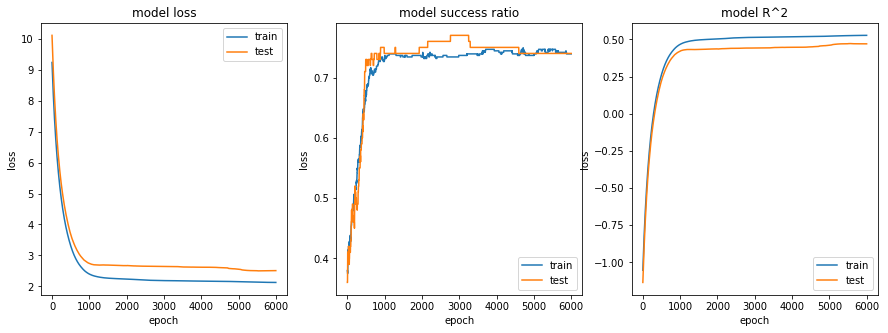

In [54]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [55]:
# make predictions
keras_in_sample = model.predict(train_X)
keras_out_sample = model.predict(test_X)

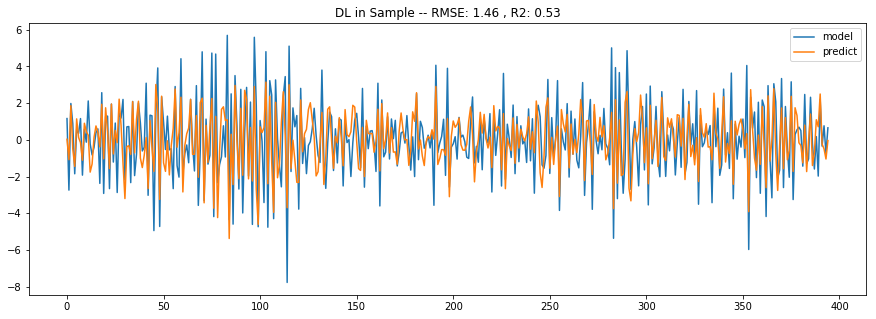

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(train_Y, keras_in_sample))
r2 = r2_score(train_Y, keras_in_sample)
plt.title('DL in Sample -- RMSE: %.2f , R2: %.2f' % (rmse, r2))
plt.legend(loc=0)
plt.show()

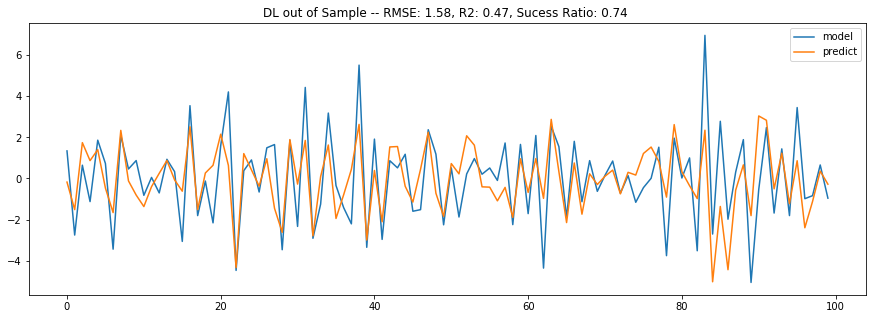

In [57]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(test_Y, keras_out_sample))
r2 = r2_score(test_Y, keras_out_sample)
# Success ratio
sr = np.mean(np.sign(keras_out_sample)==np.sign(test_Y))
plt.title('DL out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (rmse, r2, sr))
plt.legend(loc=0)
plt.show()